In [7]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.devices import global_phase
from trajectree.quant_info.noise_models import amplitude_damping
from trajectree.quant_info.circuit import Circuit
from trajectree.trajectory import quantum_channel, trajectory_evaluator
import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
import cirq
import qsimcirq
import time

from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit import transpile, QuantumCircuit
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.primitives import SamplerResult
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    amplitude_damping_error,
    thermal_relaxation_error,
)

from mqt.bench import BenchmarkLevel, get_benchmark

Benchmarking circuits

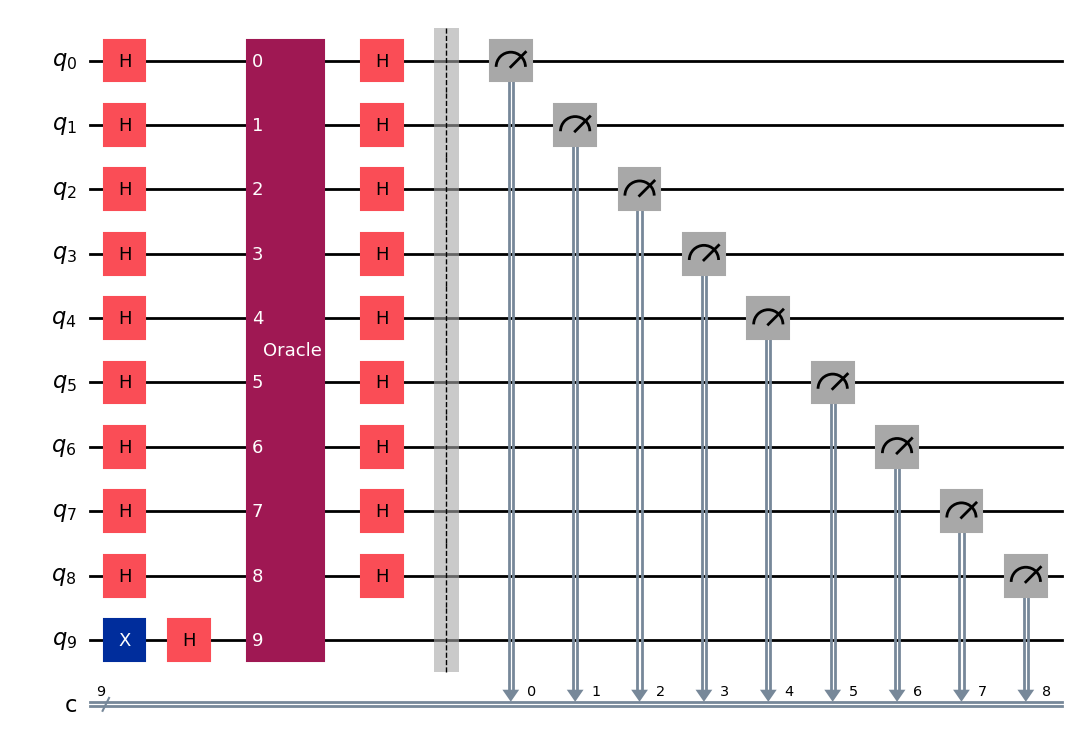

In [8]:
num_qubits = 10
qc = get_benchmark("dj", BenchmarkLevel.ALG, num_qubits)
qc.draw(output="mpl")

In [9]:
# print(dumps(qc))
target_basis = ['h', 's', 'x', 't', 'cx']
transpiled_qc_custom = transpile(qc, basis_gates=target_basis, optimization_level=1)

noise_probability = 0.99
noise_channel = amplitude_damping_error(noise_probability)

two_qubit_noise_channel = noise_channel.tensor(noise_channel)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(noise_channel, target_basis[:-1])
noise_model.add_all_qubit_quantum_error(two_qubit_noise_channel, ["cx"])

print(noise_model)
# noisy_transpiled_qc_custom = QuantumCircuit(transpiled_qc_custom.num_qubits, transpiled_qc_custom.num_clbits)
# for instr, qargs, cargs in transpiled_qc_custom.data:
#     if instr.name not in {"measure", "barrier"}:
#         noisy_transpiled_qc_custom.append(instr, qargs, cargs)
#         for q in qargs:
#             noisy_transpiled_qc_custom.append(noise_channel, [q])        

# transpiled_qc_custom = noisy_transpiled_qc_custom

# transpiled_qc_custom.draw(output="mpl")

# # for i in transpiled_qc_custom:
# #     print(i.operation.name)
# #     print([qubit._index for qubit in i.qubits])
# # transpiled_qc_custom.draw(output="mpl")

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 's', 'sx', 't', 'x']
  Instructions with noise: ['t', 's', 'cx', 'x', 'h']
  All-qubits errors: ['h', 's', 'x', 't', 'cx']


In [10]:
observable = SparsePauliOp("I"+"Z" * (num_qubits-1))

# Use the Sampler primitive for latest API
backend = AerSampler()

noisy_estimator = Estimator(
    options=dict(backend_options=dict(noise_model=noise_model), run_options=dict(shots=1000))
)

pub = (transpiled_qc_custom, observable)

job = noisy_estimator.run([pub])
result = job.result()
pub_result = result[0]
print((len(result)))
print(float(pub_result.data.evs))
print(float(pub_result.data.stds))


# estimator = Estimator()
# estimator.options.run_options = {"shots":10000}
# estimator.options.backend_options = dict(noise_model=noise_channel)
# # print(estimator.options)

# # Run the sampler
# job = estimator.run([(transpiled_qc_custom, observable)])
# result = job.result()

# pub_result = result[0]
# print(result)
# print(pub_result.data.stds)
# print(pub_result.data.evs)

1
0.92
0.0


In [14]:
import cirq

# Create Cirq qubits
num_qubits_cirq = transpiled_qc_custom.num_qubits
cirq_qubits = cirq.LineQubit.range(num_qubits_cirq)

# Map Qiskit gates to Cirq gates
gate_map = {
    'h': lambda q: cirq.H(q),
    's': lambda q: cirq.S(q),
    't': lambda q: cirq.T(q),
    'x': lambda q: cirq.X(q),
    'cx': lambda q0, q1: cirq.CNOT(q0, q1),
    'measure': lambda q: None,  # We'll handle measurements separately
    'barrier': lambda *args: None,
}

# Build the Cirq circuit
cirq_circuit = cirq.Circuit()

for circuit_instr in transpiled_qc_custom.data:
    instr = circuit_instr.operation
    qargs = circuit_instr.qubits
    cargs = circuit_instr.clbits
    gate_name = instr.name
    
    # if gate_name == 'quantum_channel':
    #     # This is the amplitude damping error
    #     # Extract the damping parameter from the Kraus operators
    #     for qarg in qargs:
    #         cirq_qubit = cirq_qubits[qarg._index]
    #         cirq_circuit.append(cirq.amplitude_damp(gamma=noise_probability)(cirq_qubit))
    
    if gate_name in gate_map and gate_name not in ['measure', 'barrier']:
        cirq_qubit_args = [cirq_qubits[q._index] for q in qargs]
        gate = gate_map[gate_name](*cirq_qubit_args)
        
        if gate is not None:
            cirq_circuit.append(gate)
            for qarg in qargs:
                cirq_qubit = cirq_qubits[qarg._index]
                cirq_circuit.append(cirq.amplitude_damp(gamma=noise_probability)(cirq_qubit))

# # Add measurements at the end
# cirq_circuit.append(cirq.measure(*cirq_qubits, key='result'))

print(f"Converted Cirq circuit with {len(cirq_circuit)} moments")
print(f"Number of operations: {len(list(cirq_circuit.all_operations()))}")
print("\nFirst 50 operations:")
for i, op in enumerate(cirq_circuit.all_operations()):
    if i >= 50:
        break
    print(f"{i}: {op}")

# Draw a portion of the circuit
print("\nCircuit diagram (first 20 moments):")
print(cirq.Circuit(list(cirq_circuit[:20])))


Converted Cirq circuit with 28 moments
Number of operations: 103

First 50 operations:
0: S(q(0))
1: S(q(1))
2: H(q(2))
3: H(q(3))
4: S(q(4))
5: S(q(5))
6: S(q(6))
7: H(q(7))
8: S(q(8))
9: X(q(9))
10: amplitude_damp(gamma=0.99)(q(0))
11: amplitude_damp(gamma=0.99)(q(1))
12: amplitude_damp(gamma=0.99)(q(2))
13: amplitude_damp(gamma=0.99)(q(3))
14: amplitude_damp(gamma=0.99)(q(4))
15: amplitude_damp(gamma=0.99)(q(5))
16: amplitude_damp(gamma=0.99)(q(6))
17: amplitude_damp(gamma=0.99)(q(7))
18: amplitude_damp(gamma=0.99)(q(8))
19: amplitude_damp(gamma=0.99)(q(9))
20: S(q(0))
21: S(q(1))
22: S(q(4))
23: S(q(5))
24: S(q(6))
25: S(q(8))
26: H(q(9))
27: amplitude_damp(gamma=0.99)(q(0))
28: amplitude_damp(gamma=0.99)(q(1))
29: amplitude_damp(gamma=0.99)(q(4))
30: amplitude_damp(gamma=0.99)(q(5))
31: amplitude_damp(gamma=0.99)(q(6))
32: amplitude_damp(gamma=0.99)(q(8))
33: amplitude_damp(gamma=0.99)(q(9))
34: H(q(0))
35: H(q(1))
36: H(q(4))
37: H(q(5))
38: H(q(6))
39: H(q(8))
40: amplitude_damp

In [69]:
# Set the "noisy repetitions" to 100.
# This parameter only affects expectation value calculations.
options = {'r': 100}
# Also set the random seed to get reproducible results.
ev_simulator = qsimcirq.QSimSimulator(qsim_options=options)
# Define observables to measure: <Z> for q0 and <X> for q1.
observable = cirq.Z(cirq_qubits[0])
for i in range(1,num_qubits):
    observable *= cirq.Z(cirq_qubits[1])
# Calculate expectation values for the given observables.
ev_results = ev_simulator.simulate_expectation_values(
    cirq_circuit,
    observables=[observable],
)
print(ev_results)

[(0.9787319641709324+0j)]


## Now, we implement the same circuit in Trajectree

In [72]:
qc = Circuit(num_qubits)
qc.qiskit_to_trajectree(transpiled_qc_custom, noise_parameter=noise_probability)

qc.perform_trajectree_simulation(100)

[0.34044384956359863,
 0.00023698806762695312,
 9.703636169433594e-05,
 7.152557373046875e-05,
 0.0008606910705566406,
 7.534027099609375e-05,
 6.437301635742188e-05,
 6.246566772460938e-05,
 6.222724914550781e-05,
 6.151199340820312e-05,
 6.031990051269531e-05,
 6.67572021484375e-05,
 6.151199340820312e-05,
 5.984306335449219e-05,
 5.936622619628906e-05,
 6.031990051269531e-05,
 5.91278076171875e-05,
 0.0008139610290527344,
 7.033348083496094e-05,
 6.437301635742188e-05,
 6.365776062011719e-05,
 6.0558319091796875e-05,
 6.031990051269531e-05,
 5.984306335449219e-05,
 6.079673767089844e-05,
 6.127357482910156e-05,
 0.0005998611450195312,
 6.508827209472656e-05,
 6.0558319091796875e-05,
 5.9604644775390625e-05,
 5.984306335449219e-05,
 5.936622619628906e-05,
 5.984306335449219e-05,
 6.0558319091796875e-05,
 5.888938903808594e-05,
 0.0006663799285888672,
 6.628036499023438e-05,
 6.198883056640625e-05,
 6.175041198730469e-05,
 6.079673767089844e-05,
 6.079673767089844e-05,
 6.079673767089

In [ ]:
def run_experiment(max_cache_nodes=-1):
    num_simulations = 100 # 20

    num_qubits = 10

    cache_size = 1
    iter = 0
    max_iter = 1
    times = []

    while iter < max_iter:  # This while loop is just to perform the entire exoeriment multiple times to get average runtime values.
        # psi, t_eval = generate_test_circuit_trajectree(cache_size, max_cache_nodes)
        qc = Circuit(num_qubits)
        
        for i in range(num_qubits):
            qc.H_gate(i)

        # Damping layer
        for i in range(num_qubits):
            qc.amplitude_damping(0.1, i)

        qc.create_trajectree()

        times_iter = qc.perform_trajectree_simulation(num_simulations)

        times.append(times_iter)
        
        iter += 1
        print("iter:", iter)

    times_avg = np.mean(np.array(times).T, axis = 1)

    avg_times = [np.mean(times_avg[:i]) for i in range(1, len(times_avg))]

    return qc
    # return times
run_experiment()